In [144]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 

In [216]:
dataset = pd.read_csv('Dataset.csv')
dataset = dataset.drop(['Unnamed: 0'],axis=1)
print(f'Size of the dataset: ', dataset.shape)

Size of the dataset:  (800, 257)


In [220]:
x = dataset.loc[:, dataset.columns!='gnd']
y = dataset.loc[:, dataset.columns=='gnd'] 

In [221]:
dataset_boston = load_boston()
x_boston = pd.DataFrame(dataset_boston.data, columns=dataset_boston.feature_names)
y_boston = pd.DataFrame(dataset_boston.target, columns=['target'])

In [222]:
# Missing Value Ratio
# Low Variance Filter

class FeatureSelection:
    """Create a module to perform feature selection"""
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def missing_value_ratio(self, threshold):
        df = self.dataframe
        df_null = df.isnull().sum()/len(df)*100
        variables = df.columns
        selectedVariables = []
        for i in range(0,len(variables)):
            if df_null[i]<=threshold:   #setting the threshold
                selectedVariables.append(variables[i])
        
        return df[selectedVariables]
    
    
    def low_variance_filter(self, threshold):
        df = self.dataframe._get_numeric_data()
        var = df.var()
        variables = df.columns
        selectedVariables = []
        for i in range(0,len(var)):
            if var[i]>=threshold:   #setting the threshold
                selectedVariables.append(variables[i])
                       
        return df[selectedVariables]       

In [223]:
# Random Forest - for feature importance 
# Backward Feature Elimination
# PCA
# PCA Plot
# TSNE

class DimensionalityReduction:
    """Create a module to dimensionality reduction"""
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def random_forest(self, x_cols, y_cols, n):
        """
        x dataframe: X part of your dataframe containing predictor variables
        y dataframe or series: Y part of your dataframe containing target variables 
        return plot
        """
        x_cols = pd.get_dummies(x_cols)
        model = RandomForestRegressor(random_state=1, max_depth=10)
        model.fit(x_cols, y_cols)
        features = x_cols.columns
        importances = model.feature_importances_
        indices = np.argsort(importances)[-n:]  # return highest n features (top 10 features)
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='g', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
        return importances, indices
        """
        # Alternate Method
        from sklearn.feature_selection import SelectFromModel # It selects the features based on the importance of their weights.
        feature = SelectFromModel(model)
        Fit = feature.fit_transform(x, y)
        """
    
    def backward_feature_elimination(self, estimator, x_cols, y_cols, n):
        """Drop variable and perform regression"""

        self.estimator = estimator
        selector = RFE(estimator, n_features_to_select=n)
        model = selector.fit(x_cols, y_cols)
        self.features = pd.DataFrame(selector.ranking_, columns=['ranking'])
        self.features_sorted = self.features.sort_values(by=['ranking'])
        features_sorted = self.features_sorted
        top_n_features = self.features_sorted[:n].index
        return features_sorted, top_n_features
        
    
    def PCA_feature_selection(self, x_cols, y_cols, n_components):
        columns = []
        pca = PCA(n_components)
        # Standardizing the features
        x_cols = StandardScaler().fit_transform(x_cols)
        pca_result = pca.fit_transform(x_cols)
        self.principalDf = pd.DataFrame(data=pca_result)
        for i in range(n_components):
            columns.append('PCA_'+str(i+1))
        self.principalDf.columns = columns
        self.principalDf = pd.concat([self.principalDf, y_cols], axis=1)
        
        return self.principalDf
        
        
#     def TSNE_(self, x_cols, y_cols, n_components = 3):
#         tsne = TSNE(n_components, n_iter=300)
#         x = self.dataframe[:, x_cols].values
#         tsne = tsne.fit_transform(x)
#         # Add conditions to to flexible when n_components is not 3
#         plt.figure(figsize=(12,8))
#         plt.title('t-SNE components')
#         plt.scatter(tsne[:,0], tsne[:,1])
#         plt.scatter(tsne[:,1], tsne[:,2])
#         plt.scatter(tsne[:,2], tsne[:,0])
        

In [224]:
FS = FeatureSelection(dataset)

In [225]:
selected_variables_mv = FS.missing_value_ratio(threshold=5)
print(f' Selected features based on # missing values: {selected_variables_mv.shape}')

 Selected features based on # missing values: (800, 257)


In [226]:
selected_variables_lv = FS.low_variance_filter(threshold=0.2)
print(f' Selected features based on low variance: {selected_variables_lv.shape}')

 Selected features based on low variance: (800, 181)


C:\Users\hoori\AppData\Local\Temp/ipykernel_49168/2482639240.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_cols, y_cols)


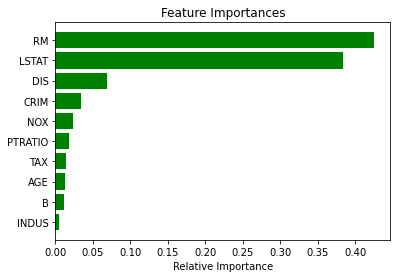

In [236]:
DR = DimensionalityReduction(dataset_boston)
selected_variables_rf, indexes = DR.random_forest(x_boston,y_boston,10)

In [237]:
print(f'Indices of top 10 important features: {indexes}')

Indices of top 10 important features: [ 2 11  6  9 10  4  0  7 12  5]


In [238]:
LR = LinearRegression()
selected_feature_RFE, indexes = DR.backward_feature_elimination(LR,x_boston,y_boston,10)

In [239]:
selected_features = x_boston.iloc[:,indexes]
print('Top 10 features selected by RFE')
selected_features.head(5)

Top 10 features selected by RFE


,CRIM,ZN,INDUS,CHAS,NOX,RM,DIS,RAD,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,4.0900,1.0,15.3,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,4.9671,2.0,17.8,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,4.9671,2.0,17.8,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,6.0622,3.0,18.7,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,6.0622,3.0,18.7,5.33


In [267]:
pca_features = DR.PCA_feature_selection(x,y,5)
pca_features.head(5)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,gnd
0,9.124285,5.852378,-1.271036,3.970371,-6.295159,0
1,2.708190,-1.088787,-2.156574,-10.158424,1.517798,0
2,9.820060,4.556152,-3.043194,-8.722459,4.411832,0
3,-2.510460,-3.207956,-2.945315,-6.479733,2.221119,0
4,-6.504475,0.295881,-1.358743,-3.231641,0.559070,0


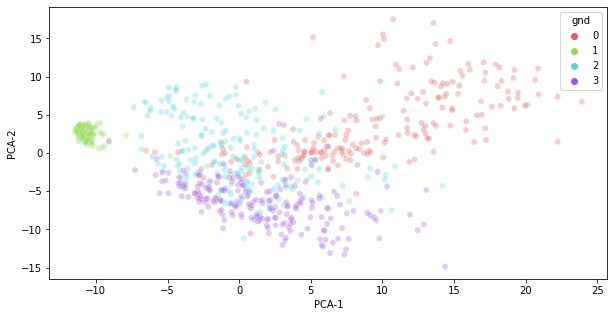

In [278]:
plt.figure(figsize=(10,5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
sns.scatterplot( x="PCA_1", y="PCA_2", hue="gnd", palette=sns.color_palette("hls", 4), data=pca_features,
                legend="full", alpha=0.3);

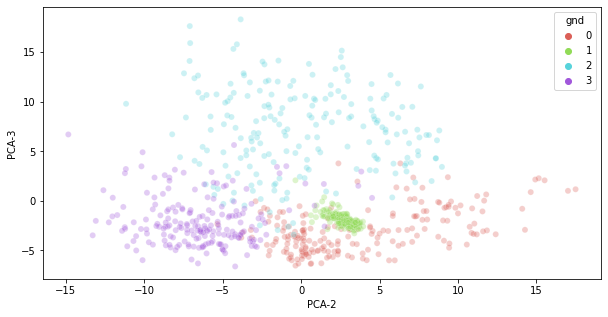

In [279]:
plt.figure(figsize=(10,5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('PCA-2')
plt.ylabel('PCA-3')
sns.scatterplot( x="PCA_2", y="PCA_3", hue="gnd", palette=sns.color_palette("hls", 4), data=pca_features,
                legend="full", alpha=0.3);

### Plot a 2-dimensional representation of the original data using t-SNE 

T-distributed Stochastic Neighbourhood Embedding (tSNE) is an unsupervised Machine Learning algorithm developed in 2008 by Laurens van der Maaten and Geoffery Hinton. It has become widely used in bioinformatics and more generally in data science to visualise the structure of high dimensional data in 2 or 3 dimensions.

What is t-SNE Why do we use PCA instead of t-SNE?
PCA it is a mathematical technique, but t-SNE is a probabilistic one. Linear dimensionality reduction algorithms, like PCA, concentrate on placing dissimilar data points far apart in a lower dimension representation.

#### What does a t-SNE plot show?

t-SNE captures structure in the sense that neighboring points in the input space will tend to be neighbors in the low dimensional space. But, some care is needed because larger distances can't necessarily be interpreted.

#### Is t-SNE a cluster?

t-SNE is a visualization tool first and a dimensionality reduction tool second. Finally, t-SNE calculates the similarity probability score in a low dimensional space in order to cluster the points together

In [283]:
tsne = TSNE(n_components=2,n_iter = 300)
tsne = tsne.fit_transform(x)
data = pd.DataFrame(tsne)
datatsne = pd.concat([data, y], axis = 1)
datatsne.columns = ["TSNE-1", "TSNE-2", "gnd"]
datatsne.head(5)

,TSNE-1,TSNE-2,gnd
0,10.265425,14.408730,0
1,8.741934,2.742428,0
2,4.557031,9.965411,0
3,7.794557,1.358923,0
4,5.562428,1.375362,0


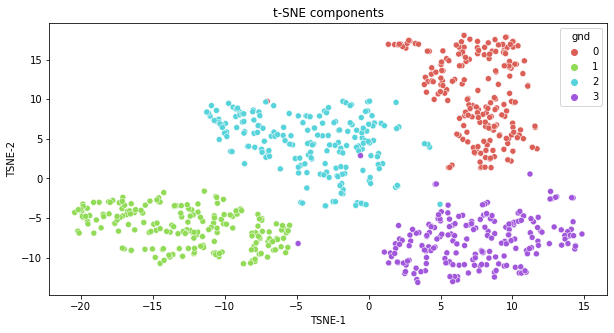

In [285]:
plt.figure(figsize=(10,5))
plt.xlabel("TSNE-1",fontsize=10)
plt.ylabel("TSNE-2",fontsize=10)
plt.title('t-SNE components')
sns.scatterplot(x="TSNE-1", y="TSNE-2", hue="gnd", palette=sns.color_palette("hls", 4), data=datatsne);